[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Images with Segment Anything 2 (SAM2)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything-2)

Segment Anything Model 2 (SAM 2) is a foundation model designed to address promptable visual segmentation in both images and videos. The model extends its functionality to video by treating images as single-frame videos. Its design, a simple transformer architecture with streaming memory, enables real-time video processing. A model-in-the-loop data engine, which enhances the model and data through user interaction, was built to collect the SA-V dataset, the largest video segmentation dataset to date. SAM 2, trained on this extensive dataset, delivers robust performance across diverse tasks and visual domains.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-2-paper.jpg)

This notebook is an extension of the official [notebook](https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/image_predictor_example.ipynb) prepared by Meta AI.

## Complementary materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-images-with-sam-2.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-segment-anything-2)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model 2 (SAM2).

[![SAM2 blogpost](https://media.roboflow.com/notebooks/examples/blog-what-is-sam-2.png)](https://blog.roboflow.com/what-is-segment-anything-2)

## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Jun 19 17:10:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies

In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 15.72 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45

In [4]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.5 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [5]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [6]:
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

### Imports

In [7]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [8]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model





In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

## Automated mask generation

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [10]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

**NOTE:** OpenCV loads images in BGR format by default, so we convert to RGB for compatibility with the mask generator.

In [11]:
IMAGE_PATH = f"{HOME}/data/dog.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

### Output format

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation

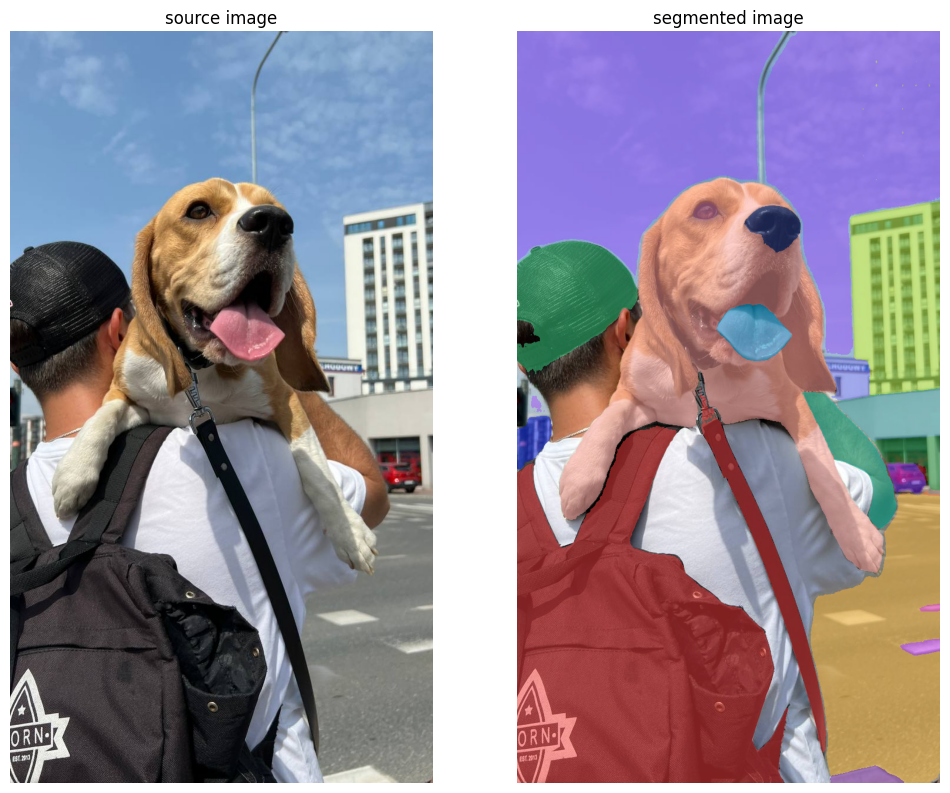

In [12]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

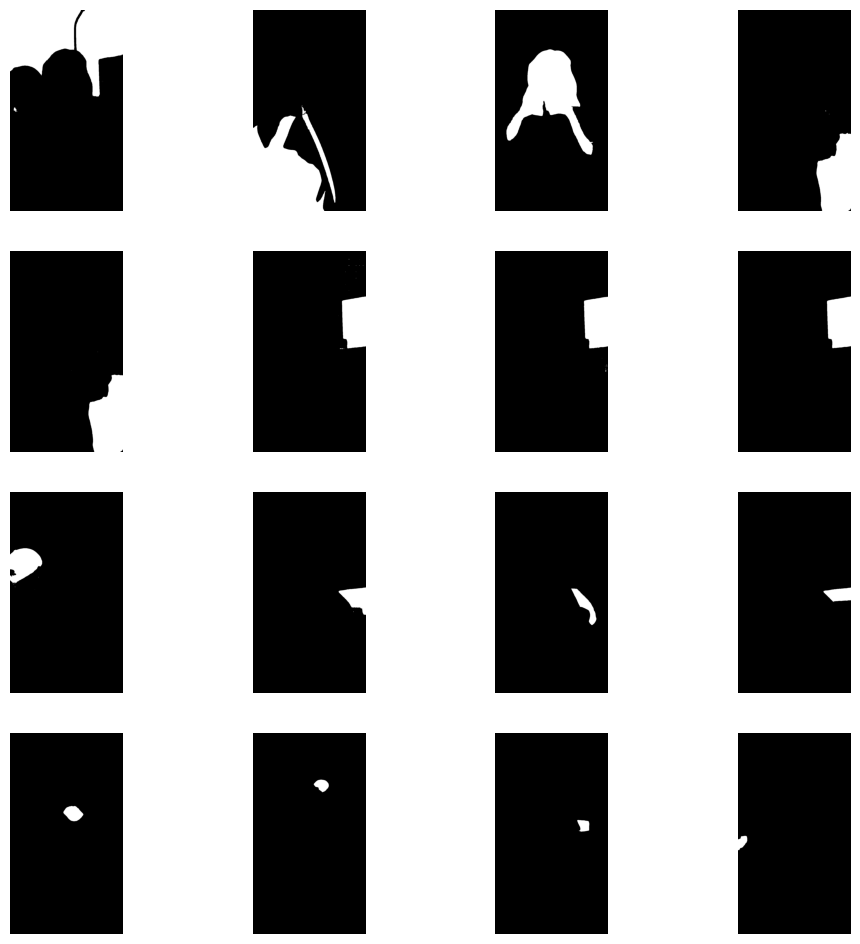

In [13]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

### Advanced automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

In [14]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [15]:
sam2_result_2 = mask_generator_2.generate(image_rgb)

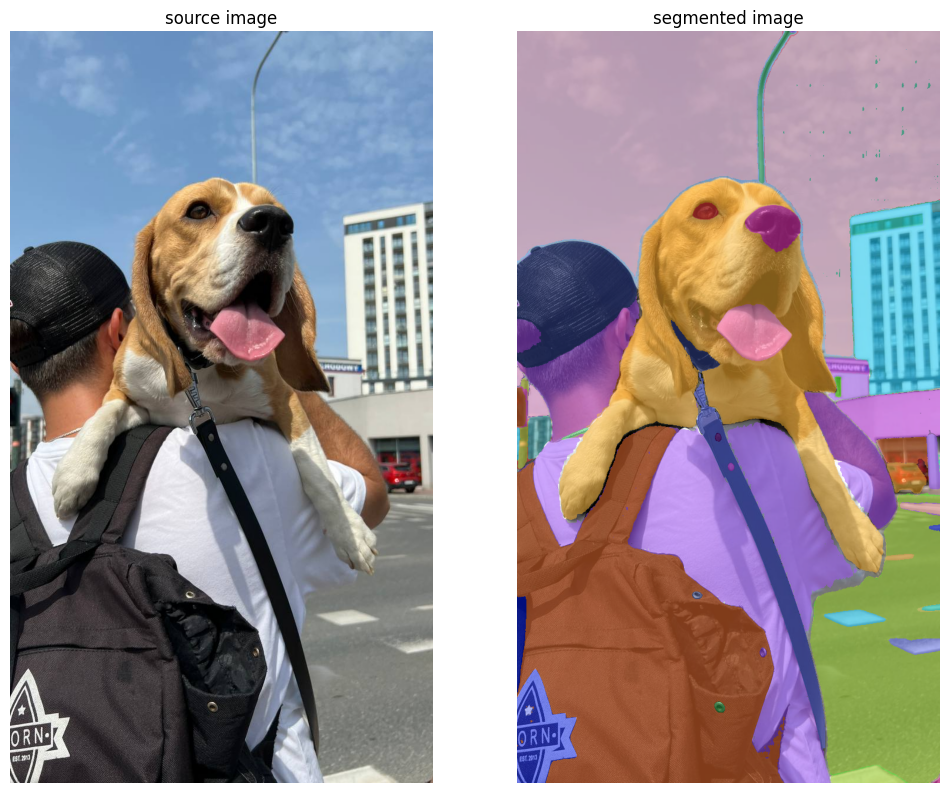

In [16]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Prompting with boxes

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [17]:
predictor = SAM2ImagePredictor(sam2_model)

In [18]:
IMAGE_PATH = f"{HOME}/data/dog-2.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

### Interactive box prompt

In [19]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to **draw bounding box** on the image 👇

In [20]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [21]:
widget.bboxes

[]

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [22]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

### Generate masks with SAM

**NOTE:** Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction. `SAM2ImagePredictor.predict` takes the following arguments:

- `point_coords` - `[np.ndarray or None]` - a `Nx2` array of point prompts to the model. Each point is in `(X,Y)` in pixels.
- `point_labels` - `[np.ndarray or None]` - a length `N` array of labels for the
point prompts. `1` indicates a foreground point and `0` indicates a
background point.
- `box` - `[np.ndarray or None]` - a length `4` array given a box prompt to the
model, in `[x_min, y_min, x_max, y_max]` format.
- `mask_input` - `[np.ndarray]` - a low resolution mask input to the model, typically coming from a previous prediction iteration. Has form `1xHxW`, where
for SAM, `H=W=256`.
- `multimask_output` - `[bool]` - if true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, `multimask_output=False` can give better results.
- `return_logits` - `[bool]` - if true, returns un-thresholded masks logits
instead of a binary mask.
- `normalize_coords` - `[bool]` - if true, the point coordinates will be normalized to the range `[0,1]` and point_coords is expected to be wrt. image dimensions.

In [23]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

# With one box as input, predictor returns masks of shape (1, H, W);
# with N boxes, it returns (N, 1, H, W).
if boxes.shape[0] != 1:
    masks = np.squeeze(masks)


### Results visualisation

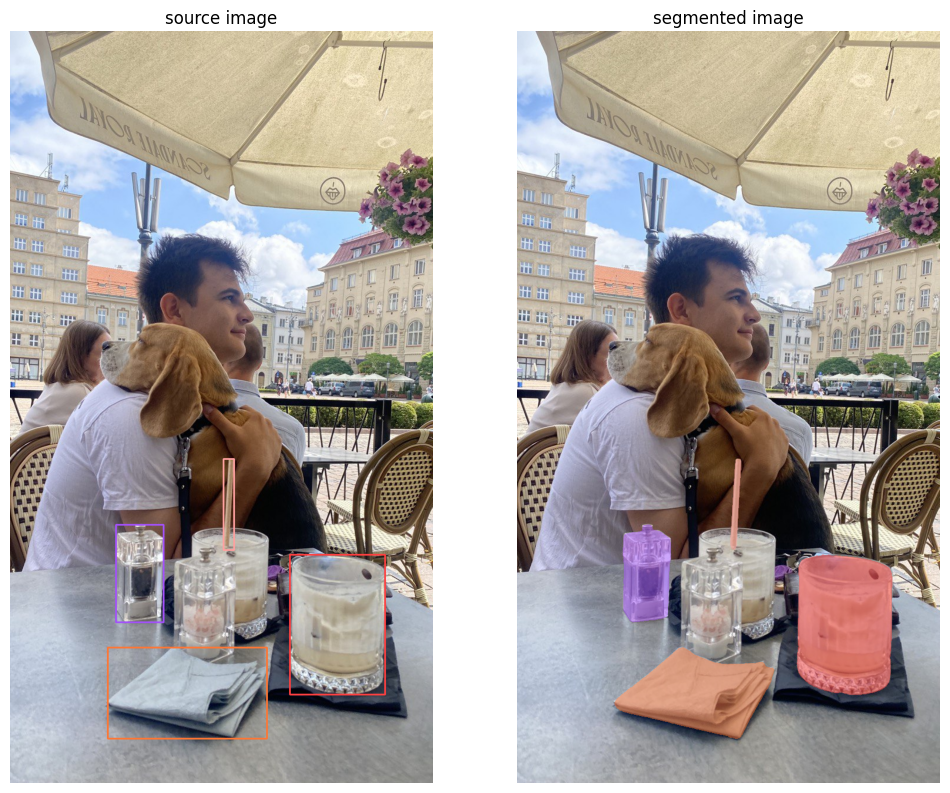

In [24]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Prompting with points

**NOTE:** Execute cell below and use your mouse to **draw points** on the image 👇

In [25]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [26]:
widget.bboxes

[]

In [27]:
default_box = [
    {'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': ''},
    {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
    {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
    {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [28]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

**NOTE:** With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

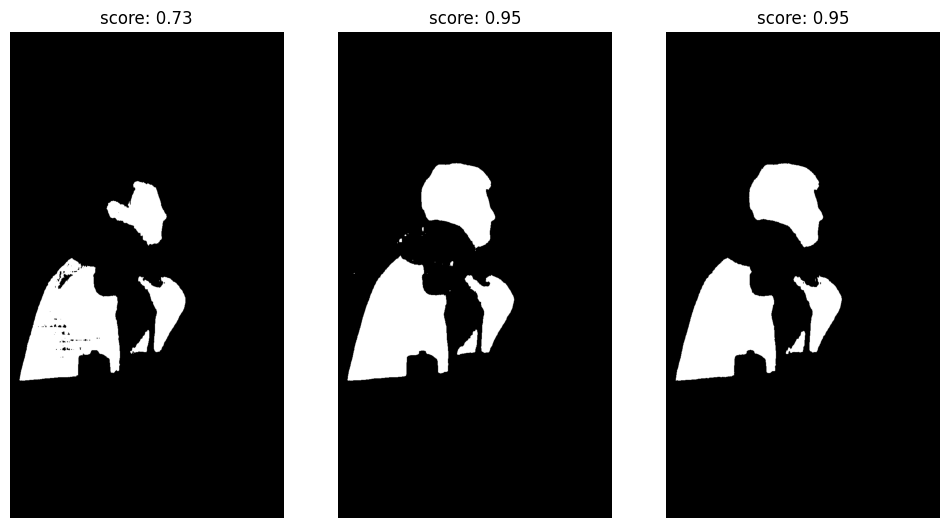

In [29]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)

In [30]:
!unzip /content/data/rgb.zip -d /content/data/rgb


Archive:  /content/data/rgb.zip
   creating: /content/data/rgb/rgb/
  inflating: /content/data/rgb/rgb/frame_001.png  
  inflating: /content/data/rgb/rgb/frame_002.png  
  inflating: /content/data/rgb/rgb/frame_003.png  
  inflating: /content/data/rgb/rgb/frame_004.png  
  inflating: /content/data/rgb/rgb/frame_005.png  
  inflating: /content/data/rgb/rgb/frame_006.png  
  inflating: /content/data/rgb/rgb/frame_007.png  
  inflating: /content/data/rgb/rgb/frame_008.png  
  inflating: /content/data/rgb/rgb/frame_009.png  
  inflating: /content/data/rgb/rgb/frame_010.png  
  inflating: /content/data/rgb/rgb/frame_011.png  
  inflating: /content/data/rgb/rgb/frame_012.png  
  inflating: /content/data/rgb/rgb/frame_013.png  
  inflating: /content/data/rgb/rgb/frame_014.png  
  inflating: /content/data/rgb/rgb/frame_015.png  
  inflating: /content/data/rgb/rgb/frame_016.png  
  inflating: /content/data/rgb/rgb/frame_017.png  
  inflating: /content/data/rgb/rgb/frame_018.png  
  inflating: /

In [ ]:
# prompt: I want a code that uses all these functions, and the stuff in this notebook, to go to thefolder /content/data/rgb, and for each frame in there, generate masks for the red mug in the image using SAM2. Save the masks and segmented images in /content/data/segmentation
# I also want this to be used:
# import torch
# from PIL import Image
# from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig, LlavaProcessor
# def detect_object(image_path: str) -> str:
#     # Load LLaVA model and processor
#     processor = LlavaProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", use_fast=True)
#     bnb_config = BitsAndBytesConfig(load_in_8bit=True,
#                 llm_int8_enable_fp32_cpu_offload=True)
#     model = LlavaForConditionalGeneration.from_pretrained(
#         "llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16, device_map="auto",
#         quantization_config = bnb_config
#     )
#     # model = LlavaForConditionalGeneration.from_pretrained(
#     #     "liuhaotian/llava-v1.5-7b", torch_dtype=torch.float16, device_map="auto",
#     #     quantization_config = bnb_config
#     # )
#     # Load and process image
#     raw_image = Image.open(image_path).convert("RGB")
#     # Define conversation using the correct format
#     conversation = [
#         {
#             "role": "user",
#             "content": [
#                 {
#                     "type": "text",
#                     "text": "What is this object? Example: 'A red tomatoe soup can'.",
#                 },
#                 {"type": "image"},
#             ],
#         }
#     ]
#     prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
#     # Process inputs
#     inputs = processor(images=raw_image, text=prompt, return_tensors="pt").to(
#         "cuda", torch.float16
#     )
#     # Generate response
#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=30,
#         num_beams=1,
#         do_sample = False
#     )
#     response = processor.decode(outputs[0], skip_special_tokens=True)

!pip install -q git+https://github.com/facebookresearch/segment-anything-2.git supervision jupyter_bbox_widget transformers bitsandbytes accelerate

import os
import cv2
import torch
import base64
import numpy as np
import supervision as sv
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from google.colab import output
from jupyter_bbox_widget import BBoxWidget
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig, LlavaProcessor

# NOTE: This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for further boost performance.
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HOME = os.getcwd()
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

# Download SAM2 checkpoints if they don't exist
!mkdir -p {HOME}/checkpoints
if not os.path.exists(CHECKPOINT):
  print(f"Downloading {CHECKPOINT}")
  !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)
predictor = SAM2ImagePredictor(sam2_model)

def detect_object(image_path: str) -> str:
    # Load LLaVA model and processor
    processor = LlavaProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", use_fast=True)
    bnb_config = BitsAndBytesConfig(load_in_8bit=True,
                llm_int8_enable_fp32_cpu_offload=True)
    model = LlavaForConditionalGeneration.from_pretrained(
        "llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16, device_map="auto",
        quantization_config = bnb_config
    )
    # Load and process image
    raw_image = Image.open(image_path).convert("RGB")
    # Define conversation using the correct format
    conversation = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What is this object? Example: 'A red tomatoe soup can'.",
                },
                {"type": "image"},
            ],
        }
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    # Process inputs
    inputs = processor(images=raw_image, text=prompt, return_tensors="pt").to(
        "cuda", torch.float16
    )
    # Generate response
    outputs = model.generate(
        **inputs,
        max_new_tokens=30,
        num_beams=1,
        do_sample = False
    )
    response = processor.decode(outputs[0], skip_special_tokens=True)
    return response # Return the response

# Ensure the input and output directories exist
input_dir = '/content/data/rgb'
output_dir = '/content/data/segmentation'
os.makedirs(output_dir, exist_ok=True)

# List all files in the input directory
image_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    print(f"Processing {image_file}...")

    # Read the image
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"Warning: Could not read image {image_path}. Skipping.")
        continue

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # You would typically use LLaVA to detect the red mug here and get bounding box/points
    # For this example, let's assume we have a placeholder for the bounding box
    # based on some external logic (e.g., hardcoded or from LLaVA analysis).
    # In a real scenario, you'd run detect_object and parse the response
    # to get coordinates. Since detect_object doesn't return coordinates,
    # we'll use a placeholder for demonstration.

    # Placeholder: Assuming LLaVA helps identify the object and we get a rough box.
    # This part needs actual implementation based on LLaVA output parsing.
    # For now, let's use a dummy box that might correspond to a mug.
    # Replace this with actual logic to get the box from LLaVA.
    # LLaVA does not directly provide bounding boxes in the output string.
    # To get bounding boxes, you would typically need a different model or
    # integrate LLaVA's description with another method (like Grounding DINO
    # or a different SAM prompting approach if LLaVA provided text prompts).
    # Since the prompt asks to use the provided LLaVA code which doesn't give boxes,
    # we will simulate obtaining a box or points based on the *idea* of identifying
    # a red mug, acknowledging this is a placeholder for a more complex integration.

    # Example: Simulate a box based on image content (this requires more sophisticated logic)
    # For simplicity, let's use a static box or a box that changes slightly per frame
    # if you have a sequence. If it's just individual images, a static box might work
    # if the mug is always in a similar location.

    # This is a placeholder and needs to be replaced with actual box detection logic.
    # A robust solution would involve:
    # 1. Using LLaVA to confirm the presence and describe the object (e.g., "a red mug").
    # 2. Using another model (like Grounding DINO) prompted with "red mug" to get a bounding box.
    # 3. Passing that bounding box to SAM2 for segmentation.

    # Given the constraints and provided functions, we'll use a dummy box and acknowledge
    # that the LLaVA -> bounding box step is missing in the provided code.
    # Let's just use the interactive widget concept as a proxy for obtaining a box for one image,
    # but for iterating through a folder, interactive is not feasible.
    # A more likely scenario would be a fixed box or points if the object's location
    # is somewhat consistent, or using LLaVA to *describe* the image and then
    # manually defining prompts based on that, or using a different model entirely.

    # Let's assume for demonstration that we somehow obtained a bounding box for the red mug.
    # This would typically involve running detect_object(image_path) and then parsing the
    # response to guide prompt generation, which is non-trivial.

    # **Simplified approach for demonstration**: Assume a box for the red mug exists.
    # Replace with your actual box detection method if available.
    # For a sequence of images, you might track the object or re-detect in each frame.
    # Let's simulate a bounding box here for testing purposes.
    # You would replace this with the output of your LLaVA processing and box extraction.

    # Example dummy box (adjust based on your images):
    # Assuming the red mug is roughly in the center-right part of the image
    image_height, image_width, _ = image_bgr.shape
    # dummy_box = np.array([[image_width * 0.6, image_height * 0.4, image_width * 0.8, image_height * 0.7]])
    # Or simulate getting a box from a function (still needs the underlying logic)
    # For this example, let's use a hardcoded box for demonstration, as the provided
    # LLaVA function doesn't give coordinates.

    # A more realistic integration with LLaVA would involve text-based prompting based on its output.
    # E.g., LLaVA says "There is a red mug", you might use text prompts with a different SAM variant or a multimodal model.
    # Given the prompt specifically asks to use SAM2 with boxes/points, and the provided LLaVA doesn't give them,
    # this part highlights a gap between the requested flow and the capabilities of the provided LLaVA code.

    # Let's proceed by assuming we have *some* way to get a box for the red mug for each image.
    # For this example, we will manually set a box, acknowledging this is not ideal for a folder of varied images without a proper detection step.

    # Placeholder: Manually defined box - REPLACE WITH ACTUAL DETECTION/PROMPTING LOGIC
    # You would get this box from LLaVA analysis or another method.
    # For demonstration, let's use a fixed box.
    # If your images are a sequence, you might need object tracking or redetection.
    red_mug_box = np.array([[300, 400, 600, 800]]) # Example coordinates: [x_min, y_min, x_max, y_max]

    if red_mug_box is not None:
        predictor.set_image(image_rgb)
        masks, scores, logits = predictor.predict(
            box=red_mug_box,
            multimask_output=False # Assuming we expect one primary mask for the object
        )

        # Select the best mask if multimask_output was True, or just use the single mask
        if masks.shape[0] != 1:
            masks = np.squeeze(masks) # Handle case where N boxes lead to N masks

        if masks.shape[0] > 0:
            # Convert mask to boolean
            masks_bool = masks.astype(bool)

            # Create segmentation images and save them
            # Apply the mask to the original image
            segmented_image = np.zeros_like(image_bgr)
            # Apply the mask to all three color channels
            segmented_image[masks_bool] = image_bgr[masks_bool]

            # Save the mask (as a binary image or boolean array)
            mask_output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_mask.png")
            cv2.imwrite(mask_output_path, masks_bool.astype(np.uint8) * 255) # Save mask as a grayscale image

            # Save the segmented image
            segmented_output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_segmented.png")
            cv2.imwrite(segmented_output_path, segmented_image)

            print(f"Saved mask and segmented image for {image_file}")
        else:
            print(f"No masks generated for the given box in {image_file}.")
    else:
        print(f"Could not determine bounding box for red mug in {image_file}. Skipping segmentation.")

print("Segmentation process finished.")
